In [36]:
import pickle
import itertools
import numpy as np
from tqdm.notebook import tqdm
from multiprocessing import Pool
import sacrebleu
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper', font_scale=0.73)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

In [20]:
wmt_scored = pickle.load(open('wmt16-19_toen_scored.pkl', 'rb'))
wmt_scored.head(1)

,lp,HITId,WorkerId,score,time,system,type,sid,reference,source,...,chrf:statistics_10,chrf:statistics_11,chrf:statistics_12,chrf:statistics_13,chrf:statistics_14,chrf:statistics_15,chrf:statistics_16,chrf:statistics_17,bert_score:f1,bleurt_score
0,de-en,3QQUBC64ZEEFIPT2SKINDZZTZ3SNXN,A0077,78,2052.0,online-G,SYSTEM,1906,Rather than having an executive make the annou...,Anstatt einen Manager die Ankündigung machen z...,...,151,95,145,150,85,144,149,76,0.941347,-0.00404


In [21]:
wmt_scored.type.value_counts()

SYSTEM    585386
REPEAT     75998
Name: type, dtype: int64

In [4]:
def pairs(x):
    for (year, lp), group in x.groupby(['year', 'lp']):
        systems = group.system.unique()
        
        for i, j in itertools.combinations(systems, 2):
            yield (year, lp), i, j
            
all_pairs = list(pairs(wmt_scored))
pairs_2019 = list(pairs(wmt_scored[wmt_scored.year == 2019]))
print(len(all_pairs))
print(all_pairs[-1])

def get_preds(all_pairs, scores, only_2019=False):
    if only_2019:
        all_pairs = pairs_2019
    
    preds = np.zeros(len(all_pairs))
    if type(scores) == type({}):
        for ii, ((year, lp), i, j) in enumerate(all_pairs):
            preds[ii] = 1 if scores[year, lp, i] - scores[year, lp, j] > 0 else 0
    else:
        for ii, ((year, lp), i, j) in enumerate(all_pairs):
            preds[ii] = 1 if scores.loc[year, lp, i] - scores.loc[year, lp, j] > 0 else 0
            
    return preds

1324
((2019, 'zh-en'), 'online-X.0', 'MSRA.MASS.6942')


In [5]:
# BLEU
def bleu_agg(x):
    cols = [ ('bleu:counts_%d' % i) for i in range(0, 4) ] + [ ('bleu:totals_%d' % i) for i in range(0, 4) ]
    cols += ['bleu:sys_len', 'bleu:ref_len']
    aggs = x[cols].sum()

    totals = [ aggs['bleu:totals_%d' % i] for i in range(0, 4) ]
    counts = [ aggs['bleu:counts_%d' % i] for i in range(0, 4) ]
    ref_len = aggs['bleu:ref_len']
    sys_len = aggs['bleu:sys_len']

    return sacrebleu.compute_bleu(counts, totals, sys_len, ref_len).score

# TER
def ter_agg(x):
    cols = [ 'ter:num_edits', 'ter:ref_length' ]
    aggs = x[cols].sum()

    num_edits = aggs['ter:num_edits']
    ref_length = aggs['ter:ref_length']

    # for one reference
    return -num_edits / ref_length


# chrf
def chrf_agg(x):
    cols = [ ('chrf:statistics_%d' % i) for i in range(0, 18) ]
    aggs = x[cols].sum()

    statistics = [ aggs['chrf:statistics_%d' % i] for i in range(0, 18) ]

    return sacrebleu.CHRF.compute_chrf(statistics, order=6, beta=2).score

def bert_score_agg(x):
    return x['bert_score:f1'].mean()

def bleurt_agg(x):
    return x['bleurt_score'].mean()

def human_agg(x):
    return x['score'].mean()

In [ ]:
cached = [ (i, pd.DataFrame(g)) for i, g in wmt_scored.groupby(['year', 'lp', 'system']) ]
labels = [ i[0] for i in cached ]

def f(metric):        
    # get agg function
    agg = globals()['%s_agg' % metric]
        
    groups = [ g.sample(n=2000, replace=True) for i, g in cached ]
    agg_means = [ agg(g) for g in groups ]
    agg_means = { label:mean for label, mean in zip(labels, agg_means) }

    flag = metric == 'bleurt'
    return get_preds(all_pairs, agg_means, only_2019=flag)

WORKERS = 12
NUM_TRIALS = 10000
CHUNKSIZE = int(NUM_TRIALS / WORKERS / 10)
metrics = ['bleurt', 'bleu', 'ter', 'chrf', 'bert_score']
#metrics = ['true_preds', 'human']
results = {}

with Pool(WORKERS) as p:
    for metric in tqdm(metrics):
        it = tqdm(p.imap_unordered(f, [metric]*NUM_TRIALS, chunksize=CHUNKSIZE), total=NUM_TRIALS)
        output = list(it)
        
        metric_results = np.array(output, dtype=np.int64)
        
        main_predictions = np.apply_along_axis(lambda x:
                                       np.argmax(np.bincount(x)),
                                       axis=0,
                                       arr=metric_results)

        results[metric] = main_predictions

In [ ]:
cached = [ (i, pd.DataFrame(g)) for i, g in wmt_scored.groupby(['year', 'lp', 'system']) ]
labels = [ i[0] for i in cached ]

def f(x):   
    n, metric = x
    # get agg function
    agg = globals()['%s_agg' % metric]
        
    groups = [ g.sample(n=n, replace=True) for i, g in cached ]
    agg_means = [ agg(g) for g in groups ]
    agg_means = { label:mean for label, mean in zip(labels, agg_means) }

    flag = metric == 'bleurt'
    return get_preds(all_pairs, agg_means, only_2019=flag)

WORKERS = 12
NUM_TRIALS = 3000
CHUNKSIZE = int(NUM_TRIALS / WORKERS / 10)
xs = list(range(200, 1001, 200))
metrics = ['bleurt', 'bleu', 'ter', 'chrf', 'bert_score']
#metrics = ['true_preds', 'human']
agreements = {}

with Pool(WORKERS) as p:
    for metric in tqdm(metrics):
        agreements[metric] = {}
        for i in xs:
            it = tqdm(p.imap_unordered(f, [(i, metric)]*NUM_TRIALS, chunksize=CHUNKSIZE), total=NUM_TRIALS)
            output = list(it)

            metric_results = np.array(output, dtype=np.int64)
            agreements[metric][i] = (metric_results == results[metric]).mean()

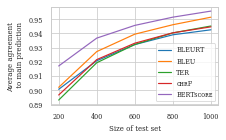

In [37]:
plt.figure(figsize=(3, 1.8))

names = {
    'bleu' : 'BLEU',
    'bleurt' : 'BLEURT',
    'ter': 'TER',
    'chrf' : 'ᴄʜʀF',
    'bert_score' : 'BERTsᴄᴏʀᴇ'
}


for metric in results:
    ys = [ agreements[metric][x] for x in xs ]
    
    ax = sns.lineplot(x=xs, y=ys, label=names[metric])
    
ax.set(xlabel='Size of test set', ylabel='Average agreement \n to main prediction')
ax.yaxis.grid(True)
#ax.legend(loc='upper right')

plt.savefig('metric_convergence_wmt.pdf', bbox_inches='tight')